# Create Hosted Imagery Layer by transfering data from existing Cloud store to ArcGIS Online with ArcGIS Notebook

With ArcGIS Notebook Advance and ArcGIS API for Python, user can transfer their existing imagery data in the cloud store to ArcGIS Online and create Hosted Imagery Layer with ArcGIS Image for ArcGIS Online.  

- Identify the source cloud store from supported platform and create a cloud storage connection with the access credential  
- Sign into ArcGIS Online org and acquire the SAS token for upload storage
- Transfer the imagery data from source cloud store to ArcGIS Online upload storage 
- Create tiled/dynamic imagery layer from the uploaded imagery data


In [1]:
# The level in source bucket that we want to copy data from. Must match the source path and source case (example: Frostproof )
source_folder_level = "Lakeland"

# The level in destination AGOL Azure container that we want to transfer the data to (example: waldo-ian/Frostproof )
target_folder_level = "waldo-ian/Lakeland"

# The name of Hosted Imagery Layer we want to publish (example: Frostproof_10_01_2022 )
layer_name = "Lakeland"

### Create a connection to an ArcGIS Online organization with ArcGIS Image 

In [4]:
import arcgis
from arcgis.raster import *
from arcgis.raster.analytics import *
from arcgis.gis import GIS
from datetime import datetime

arcgis.env.verbose=True

In [5]:
%%capture --no-display

# Connect to ArcGIS Online Organization as current log in user
gis = GIS("home")
gis

GIS @ https://www.arcgis.com version:10.2

### Create Cloud Storage connection to the user's source storage

In this example, user has existing data in a Azure blob storage container. 
A cloud storage connection file (.acs) can be created with the access credential from user to prepare for data transfer to ArcGIS Online. 
The cloud storage connection file will be created in the temporary file system storage of ArcGIS Notebook and can be deleted after the data transfer has completed. 

In [6]:
# Use "arcpy" API to create cloud storage connection. Note "arcpy" is only available with ArcGIS Notebook Advanced
import arcpy

In [ ]:
arcpy.env.overwriteOutput = 1

folder_name = "/arcgis/home"
src_connection_file = "waldo-ian_s3.acs"
platform = "AMAZON"
container_name = "waldo-ian"
account_name = "" #access key
access_key = "" #secret key

source_connection = arcpy.management.CreateCloudStorageConnectionFile(
    out_folder_path=folder_name, 
    out_name=src_connection_file,
    service_provider="AMAZON", 
    bucket_name=container_name, 
    access_key_id=account_name, 
    secret_access_key=access_key)

### Create Cloud Storage connection to ArcGIS Online's cloud storage

In order to create hosted imagery layer, user's imagery data needs to be transferred to the ArcGIS Online's cloud storage. The following example shows how user can also establish a cloud storage connection with ArcGIS Online's blob cloud storage also through creating cloud storage connection file.

In [7]:
# Request direct access URL from ArcGIS Online org with the current log in ArcGIS Online user

from arcgis.raster.utils import *

access_url = arcgis.raster.utils.generate_direct_access_url(expiration=1440, gis=gis)
account_name = access_url.split("//")[1].split(".")[0].split("-")[1]
container_name = access_url.split("/")[3].split("?")[0]
config_options = "AZURE_SAS " + access_url.split("?")[1]

print("access_url: " + access_url)
print("account_name: " + account_name)
print("container_name: " + container_name)
print("config_options: " + config_options)

access_url: https://stg-arcgisazureimagery1.az.arcgis.com/uujciiezafldbdxe-1b71292636834f74b4b0cba25ac1b960?sv=2018-03-28&sr=c&sig=1FlAHgo7qQz7Vm5qjhHLIW2uZJACFIgKTcP%2BVd%2Fgoa8%3D&st=2022-10-07T01%3A36%3A02Z&se=2022-10-08T01%3A41%3A02Z&sp=racwdl
account_name: arcgisazureimagery1
container_name: uujciiezafldbdxe-1b71292636834f74b4b0cba25ac1b960
config_options: AZURE_SAS sv=2018-03-28&sr=c&sig=1FlAHgo7qQz7Vm5qjhHLIW2uZJACFIgKTcP%2BVd%2Fgoa8%3D&st=2022-10-07T01%3A36%3A02Z&se=2022-10-08T01%3A41%3A02Z&sp=racwdl


In [9]:
# Create cloud storage connection file with the information from the direct access URL

folder_name = "/arcgis/home"
target_connection_file = "agol_azure_Lakeland.acs"

source_connection = arcpy.management.CreateCloudStorageConnectionFile(
    out_folder_path=folder_name, 
    out_name=target_connection_file,
    service_provider="AZURE", 
    bucket_name=container_name, 
    access_key_id=account_name,
    config_options=config_options)

### Now Transfer the image data from user cloud storage to ArcGIS Online cloud storage

With the Transfer File tool, user can transfer the imagery data from its own cloud store to ArcGIS Online's cloud storage. 
The data transfer is happening through ArcGIS Notebook. Data is read from user's cloud storage, stream through Notebook server then upload to ArcGIS Online's cloud storage.  


In [11]:
dataset = '/arcgis/home/agol_azure_Lakeland.acs'

data_url = os.path.join(access_url.split("?")[0], "_images", target_folder_level)
print("data_url: " + data_url)

data_url: https://stg-arcgisazureimagery1.az.arcgis.com/uujciiezafldbdxe-1b71292636834f74b4b0cba25ac1b960/_images/waldo-ian/Lakeland


In [ ]:
import os

from datetime import datetime
start = datetime.now() 
print("start time: ", start)

folder_name = "z:/arcgis/home"
src_connection_file = "waldo-ian_s3.acs"
target_connection_file = "agol_azure_Lakeland.acs"

source = os.path.join(folder_name, src_connection_file, source_folder_level)
target = os.path.join(folder_name, target_connection_file, "_images", target_folder_level)

arcpy.management.TransferFiles(source, target, "*.tif")

end = datetime.now()
print("end time: ", end)
duration  = end - start
print("duration: " , duration)

start time:  2022-10-07 01:43:34.753082


## Create Hosted Imagery Layer from the data transferred to the ArcGIS Online cloud store

With user's data transferred to the ArcGIS Online cloud store, ArcGIS API for Python can be used to create the hosted imagery layer. 

In [20]:
# The following code snippet will convert the uploaded images to a single Tiled Imagery Layer
# by mosaicking multiple rasters

start = datetime.now() 
print("start time: ", start)

#data_url = "https://stg-arcgisazureimagery1.az.arcgis.com/uujciiezafldbdxe-1b71292636834f74b4b0cba25ac1b960/_images/waldo-ian/98f15e62-5fc8-42c3-9a73-8a7b5d52d849/2022-10-01T09:12:07.272048/OrthoPhoto/Area2"
#layer_name = "Waldo-Ian-Area2"

#data_url = "https://stg-arcgisazureimagery1.az.arcgis.com/uujciiezafldbdxe-1b71292636834f74b4b0cba25ac1b960/_images/waldo-ian/c70bc32e-6994-49dd-93c2-c6ba4946eefc/2022-10-03T01:17:02.597696/Orthophoto/Arcadia_noclouds"
#layer_name = "Waldo-Ian-Acadia_noclouds"

data_url = os.path.join(access_url.split("?")[0], "_images/waldo-ian/Frostproof")

ImageryLayer = arcgis.raster.analytics.copy_raster(
    input_raster=data_url,
    output_name=layer_name,
    raster_type_name="Raster Dataset",
    context={"outSR":{"wkid":3857},
            "resamplingMethod":"BILINEAR",
            "compression":"LERC 0",
            "buildFootprints":False,
            "defineNodata":True,
            "noDataArguments":{"noDataValues":[0],
                               "compositeValue":True}
          },
    gis=gis)

end = datetime.now()
print("end time: ", end)
duration  = end - start
print("duration: " , duration)

start time:  2022-10-06 23:39:53.441928
Submitted.
Executing...
Start Time: Thursday, October 6, 2022 11:40:03 PM
Hosted Imagery Privilege Check: OK
Image service {'name': 'Frostproof', 'serviceUrl': 'https://tiledimageservices1.arcgis.com/uujCiiEZAflDbdxE/arcgis/rest/services/Frostproof/ImageServer'} already existed.
Output item id is: 3923dc4c016d43c8b6d3c5c79f318617
Output image service url is: https://tiledimageservices1.arcgis.com/uujCiiEZAflDbdxE/arcgis/rest/services/Frostproof/ImageServer
Output cloud raster name is: Frostproof
Input is a valid url https://stg-arcgisazureimagery1.az.arcgis.com/uujciiezafldbdxe-1b71292636834f74b4b0cba25ac1b960/_images/waldo-ian/Frostproof
Input raster is: https://stg-arcgisazureimagery1.az.arcgis.com/uujciiezafldbdxe-1b71292636834f74b4b0cba25ac1b960/_images/waldo-ian/Frostproof
Org ID is: uujCiiEZAflDbdxE
Org ID is: uujCiiEZAflDbdxE
Hosted data folder is: /cloudStores/uujCiiEZAflDbdxE/3923dc4c016d43c8b6d3c5c79f318617
Finished creating empty mosai

<Item title:"Waldo-Ian-Area2" type:Imagery Layer owner:d.wright_IVT>
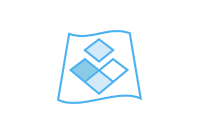

In [6]:
# Add the newly create Hosted Imagery Layer to the map, user has the option to create dynamimc imagery layer as well
# from uploaded images.

WaldoIanArea2 = gis.content.search(query='Waldo-Ian-Area2 AND owner:d.wright_IVT', 
                                  item_type='Imagery Layer')[0]
WaldoIanArea2

In [9]:
# Add the Tiled Imagery Layer to Map
MyMap = gis.map("Fort Meade, FL")
MyMap.add_layer(WaldoIanArea2)
MyMap

MapView(layout=Layout(height='400px', width='100%'))